In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
import os
import torch
import random
os.environ["DGLBACKEND"] = "pytorch"

from collections import Counter
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import SpectralClustering, KMeans, AffinityPropagation, MeanShift

In [2]:
path1 = '.../Данные по компаниям заполненные.xlsx'
path2 = '.../Степени связи для компаний.xlsx'

data = pd.read_excel(path1, index_col = 'Unnamed: 0')
links = pd.read_excel(path2).drop(labels = ['Unnamed: 0', 'Unnamed: 0.1'], axis = 1)

data = data.fillna(data.mean())
data_copy = data.copy()
columns_to_normalize = data.columns[1:]

scaler = StandardScaler()
data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])

companies_lst = dict(np.concatenate(
    (links[['Проверяемые объекты', 'ИНН']],
     links[['Контрольные объекты', 'ИНН.1']])
  )) # dict | {name: inn}

In [3]:
G = nx.from_pandas_edgelist(links, 'Проверяемые объекты', 'Контрольные объекты')

connected_components = list(nx.connected_components(G))
largest_component = max(connected_components, key=len)

G_con = G.subgraph(largest_component)
nodes_nx = list(G_con.nodes())

# data for each node

data_to_dict = dict() # dict | {'company name' : list of data}
for node in nodes_nx:
  feature = (data.where(
      data['INN'] == companies_lst[node])
      .dropna()
      .drop(labels = ['INN', 'Руководство - ИНН'], axis = 1)
      .values[0])

  data_to_dict[node] = torch.tensor(feature, dtype = torch.float)

nx.set_node_attributes(G = G_con, values = data_to_dict, name = 'data')

pos_main = nx.spring_layout(G_con)

# the Laplace matrix
L = nx.laplacian_matrix(G_con).toarray()

# the adjacency matrix
adjacency_matrix = nx.adjacency_matrix(G_con).toarray()

## **Louvain Algorithm**

In [4]:
communities_GMC = nx.community.louvain_communities(G_con)

# modularity
print('modularity =', nx.community.modularity(G_con, communities_GMC))

communities_luv = dict()
for i in range(len(communities_GMC)):
  for j in communities_GMC[i]:
    communities_luv[j] = i

community_colors = {}
for i, community_id in enumerate(set(communities_luv.values())):
    community_colors[community_id] = plt.cm.tab20(i % 20)

vis_G = nx.Graph()

for node in G_con.nodes():
    vis_G.add_node(node)

for edge in G_con.edges():
    u, v = edge
    community_u = communities_luv[u]
    community_v = communities_luv[v]
    if community_u == community_v:
        # If nodes are in the same community, color the edge and node green
        vis_G.add_edge(u, v, color=community_colors[community_u])
        vis_G.nodes[u]['color'] = community_colors[community_u]
        vis_G.nodes[v]['color'] = community_colors[community_u]
    else:
        vis_G.add_edge(u, v, color='black')

########### visualization ###########
# pos = nx.spring_layout(vis_G)
# plt.figure(figsize = (20, 20))

# nx.draw_networkx(
#     vis_G,
#     pos,
#     with_labels = False,
#     node_color=[node[1]['color'] for node in vis_G.nodes(data=True)],
#     node_size=50,
#     edge_color=[edge[2]['color'] for edge in vis_G.edges(data=True)])
# plt.show()

modularity = 0.8492160373263887


## Method of community identification based on spectral clustering

In [5]:
sc = SpectralClustering(n_clusters=30,
                        affinity='precomputed',
                        random_state=80)

sc.fit(adjacency_matrix)

labels = sc.labels_
labels_sc = labels.copy()

# new graph with community assignments

communities_spectral = {}
for node, label in zip(G_con.nodes(), labels):
    if label not in communities_spectral:
        communities_spectral[label] = []
    communities_spectral[label].append(node)

print("Basic properties of a graph")
print('modularity =', nx.community.modularity(G_con, communities_spectral.values()))
coverage, performance = nx.community.partition_quality(
    G = G_con,
    partition = communities_spectral.values())
print('coverage =', coverage, '\nperformance =', performance)

print('\nNumber of companies in each group')
display(pd.DataFrame(Counter(labels).items()).sort_values(by=0).set_index(0).T)

Basic properties of a graph
modularity = 0.815741644965278
coverage = 0.953125 
performance = 0.8844597929675231

Number of companies in each group


,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
1,17,276,6,111,7,8,14,9,192,11,...,16,26,17,5,47,16,38,12,17,22


The largest group is 5

The smallest is 13, 9, 15, 7, 4

In [6]:
res_df1 = pd.DataFrame({'company': list(G_con.nodes()), 'labels': labels})
res_df1['inn'] = res_df1['company'].apply(lambda x: companies_lst[x])

cm = sns.light_palette('green', as_cmap = True)

print("labels = 5")
lst_inn = res_df1.where(res_df1['labels'] == 5).dropna()['inn'].values
display(data
        .where(data['INN'].isin(lst_inn))
        .dropna()
        .describe()
        .iloc[1:-1, 2:]
        .style.background_gradient(cmap = cm))

print('\nlabels = 13')
lst_inn = res_df1.where(res_df1['labels'] == 13).dropna()['inn'].values
display(data
        .where(data['INN'].isin(lst_inn))
        .dropna()
        .describe()
        .iloc[1:-1]
        .style.background_gradient(cmap = cm))

labels = 5


,"Возраст компании, лет",Принадлежность к госсектору,ИФР,Размер компании,"2022, Доходы, RUB","2023, Основные средства , RUB","2023, Чистые активы, RUB","2023, Активы всего, RUB","2023, Выручка, RUB","2023, Себестоимость продаж, RUB","2023, Валовая прибыль (убыток), RUB","2023, Прибыль (убыток) от продажи, RUB","2023, Проценты к получению, RUB","2023, Проценты к уплате, RUB","2023, Прибыль (убыток) до налогообложения , RUB","2023, Текущий налог на прибыль, RUB","2023, Чистая прибыль (убыток), RUB","2023, EBIT, RUB","2023, Поступления от текущих операций, RUB","2023, Поступления от продаж, RUB","2023, Поступление денежных средств всего, RUB","2023, Платежей всего, RUB","2023, Соотношение валовой прибыли к активам компании, %","2023, Cooтношение дебиторской задолженности к активам компании, %","2023, Доля рабочего капитала в активах компании, %","2023, Коэффициент оборачиваемости совокупных активов, %","2023, Коэффициент покрытия процентов по EBIT, %","2023, Соотношение чистого долга к капиталу, %","2023, Соотношение совокупного долга к EBIT, %","2023, Чистая норма прибыли, %","2022, Валовая рентабельность, %","2023, Валовая рентабельность, %","2023, Рентабельность продаж, %","2023, Доля себестоимости как процент от выручки, %","2023, Коэффициент текущей ликвидности, %","2023, Коэффициент быстрой ликвидности, %","2023, Коэффициент абсолютной ликвидности, %"
mean,-1.279349,-0.361499,1.266129,0.703469,-0.289421,-0.105078,-0.125565,-0.149568,-0.036770,0.052149,-0.072459,-0.136668,-0.113098,-0.200383,-0.203591,0.227864,-0.196821,-0.190381,-0.094686,0.159908,-0.155498,-0.155858,0.003869,-0.830034,0.037409,-0.096290,-0.047937,-0.039760,1.140427,-0.033428,0.053415,0.094605,0.068044,-0.113444,-0.003926,-0.098560,-0.111943
std,0.626109,0.000000,0.155314,0.563504,0.022796,0.003556,0.000903,0.015912,0.199294,0.226173,0.128322,0.098360,0.116608,0.081895,0.005883,0.032705,0.003899,0.002804,0.207345,0.344962,0.009884,0.010776,0.204206,0.431039,0.000321,0.004488,0.000002,0.001826,3.705997,0.004799,0.007946,0.013955,0.002516,0.005913,0.260380,0.002558,0.010302
min,-1.624555,-0.361499,1.090344,-0.209511,-0.297513,-0.108232,-0.126587,-0.158232,-0.251927,-0.260050,-0.221694,-0.171808,-0.252291,-0.238082,-0.208097,0.168716,-0.200355,-0.196995,-0.255209,-0.261759,-0.161808,-0.162530,-0.500966,-1.092907,0.036867,-0.103273,-0.047941,-0.041943,-0.718387,-0.044614,0.037681,0.078718,0.062495,-0.126512,-0.101431,-0.100376,-0.117397
25%,-1.514089,-0.361499,1.123048,0.703469,-0.297513,-0.107865,-0.125890,-0.157259,-0.249097,-0.164967,-0.215742,-0.171417,-0.249430,-0.235060,-0.206336,0.224533,-0.198729,-0.190129,-0.255200,-0.251965,-0.161151,-0.161878,0.072106,-1.089418,0.037250,-0.097460,-0.047939,-0.040887,-0.255369,-0.032783,0.053151,0.087144,0.067572,-0.113238,-0.101387,-0.100361,-0.117373
50%,-1.514089,-0.361499,1.237513,1.007796,-0.297504,-0.107043,-0.125781,-0.156180,0.010468,0.213664,-0.021367,-0.171349,-0.051683,-0.233646,-0.204887,0.226826,-0.197528,-0.189068,-0.228083,0.409845,-0.159984,-0.160708,0.072106,-1.064147,0.037334,-0.097460,-0.047936,-0.040299,0.003862,-0.032783,0.053151,0.087144,0.068926,-0.113238,-0.095939,-0.099871,-0.117322
75%,-1.458856,-0.361499,1.425562,1.007796,-0.297451,-0.100815,-0.125592,-0.151008,0.145616,0.213664,0.040070,-0.171339,-0.016235,-0.219948,-0.204299,0.230928,-0.197035,-0.188939,0.154764,0.409845,-0.155608,-0.156339,0.072106,-0.767800,0.037740,-0.095873,-0.047936,-0.039049,0.055503,-0.031840,0.054116,0.103455,0.068926,-0.111990,-0.091330,-0.097636,-0.113036



labels = 13


,INN,Руководство - ИНН,"Возраст компании, лет",Принадлежность к госсектору,ИФР,Размер компании,"2022, Доходы, RUB","2023, Основные средства , RUB","2023, Чистые активы, RUB","2023, Активы всего, RUB","2023, Выручка, RUB","2023, Себестоимость продаж, RUB","2023, Валовая прибыль (убыток), RUB","2023, Прибыль (убыток) от продажи, RUB","2023, Проценты к получению, RUB","2023, Проценты к уплате, RUB","2023, Прибыль (убыток) до налогообложения , RUB","2023, Текущий налог на прибыль, RUB","2023, Чистая прибыль (убыток), RUB","2023, EBIT, RUB","2023, Поступления от текущих операций, RUB","2023, Поступления от продаж, RUB","2023, Поступление денежных средств всего, RUB","2023, Платежей всего, RUB","2023, Соотношение валовой прибыли к активам компании, %","2023, Cooтношение дебиторской задолженности к активам компании, %","2023, Доля рабочего капитала в активах компании, %","2023, Коэффициент оборачиваемости совокупных активов, %","2023, Коэффициент покрытия процентов по EBIT, %","2023, Соотношение чистого долга к капиталу, %","2023, Соотношение совокупного долга к EBIT, %","2023, Чистая норма прибыли, %","2022, Валовая рентабельность, %","2023, Валовая рентабельность, %","2023, Рентабельность продаж, %","2023, Доля себестоимости как процент от выручки, %","2023, Коэффициент текущей ликвидности, %","2023, Коэффициент быстрой ликвидности, %","2023, Коэффициент абсолютной ликвидности, %"
mean,6583230170.807693,0.182812,-0.027047,0.961782,-0.523908,-0.443609,-0.193701,0.635252,0.357352,0.314867,0.207218,0.229897,0.115152,0.174449,-0.173037,0.103567,0.013788,-0.222647,-0.012766,0.116658,-0.098294,-0.091606,-0.112541,-0.113324,-0.468404,0.031785,0.022888,-0.085372,-0.002667,-0.037809,0.069232,-0.028527,0.041422,0.026907,-0.062659,-0.051230,-0.079357,-0.078350,-0.095479
std,2243899399.118198,0.998726,0.850075,1.575862,0.927067,1.076157,0.208629,3.541412,2.242412,2.133715,1.643025,1.700514,1.358784,1.444005,0.137516,1.197870,0.741960,1.668462,0.611551,1.153199,0.298453,0.341976,0.101558,0.101491,0.800391,1.047291,0.066550,0.021200,0.198407,0.007712,0.017760,0.012288,0.068406,0.270535,0.644493,0.285773,0.082421,0.082494,0.042570
min,1655043430.000000,-1.624229,-1.514089,-0.361499,-1.591398,-1.426819,-0.297513,-0.108230,-0.156822,-0.158858,-0.251923,-0.260178,-0.228786,-0.184809,-0.251849,-0.238220,-0.280308,-8.292934,-0.272216,-0.239248,-0.255203,-0.262367,-0.161788,-0.162500,-3.626838,-1.045961,-0.301419,-0.103268,-0.052553,-0.039694,-0.000000,-0.031897,-0.287371,-1.294731,-3.221722,-0.149074,-0.101409,-0.100370,-0.117391
25%,5866301761.750000,-0.819685,-0.657977,-0.361499,-1.223476,-1.426819,-0.285176,-0.108015,-0.124748,-0.157346,-0.249546,-0.257799,-0.220925,-0.172056,-0.250058,-0.235039,-0.203672,0.085988,-0.196127,-0.189488,-0.251688,-0.259106,-0.160725,-0.161666,-0.449068,-0.791245,0.037276,-0.097135,-0.047976,-0.039358,0.073333,-0.031878,0.056368,0.079328,0.067401,-0.116405,-0.101239,-0.100245,-0.117205
50%,7708417465.000000,0.885244,0.087668,-0.361499,-0.757442,-0.818165,-0.271699,-0.106471,-0.120667,-0.150434,-0.231196,-0.238685,-0.214433,-0.169603,-0.239598,-0.162395,-0.201357,0.213716,-0.194635,-0.186356,-0.232433,-0.247029,-0.156562,-0.156995,-0.302332,-0.264921,0.037350,-0.088736,-0.047902,-0.039326,0.073803,-0.031878,0.057708,0.084385,0.069010,-0.112995,-0.101121,-0.100096,-0.116853
75%,7717625222.250000,0.968439,0.667614,2.766256,-0.087006,1.007796,-0.178506,-0.085114,-0.106812,-0.082385,-0.037255,-0.027803,-0.110067,-0.079771,-0.211690,-0.026894,-0.125546,0.223668,-0.128004,-0.064528,-0.052090,-0.021984,-0.121856,-0.124223,-0.057072,0.782937,0.037418,-0.085835,-0.047830,-0.039288,0.075138,-0.031877,0.060524,0.089082,0.069268,-0.108837,-0.100085,-0.099067,-0.098404


In [7]:
res = []
for i in range(30):
  lst_inn = res_df1.where(res_df1['labels'] == i).dropna()['inn'].values
  res.append(data_copy
             .where(data['INN'].isin(lst_inn))
             .dropna()[['2023, Чистые активы, RUB', '2023, Коэффициент текущей ликвидности, %']]
             .mean()
             .values)

display(pd.DataFrame(res, columns = ['Среднее значение Чистая Прибыль',
                             'Среднее значение Коэф. Текущей Ликвидности']).head(8))

######### visualization ##########

# plt.figure(figsize = (20, 20))
# nx.draw_networkx(G = G_con, pos = pos,
#                  with_labels = False,
#                  node_color = list(labels),
#                  node_size = 50,
#                  cmap = plt.cm.Set1)

# plt.show()

,Среднее значение Чистая Прибыль,Среднее значение Коэф. Текущей Ликвидности
0,1.599105e+10,57.755368
1,3.908233e+10,66.176962
2,1.886653e+11,946.641510
3,2.775781e+11,1252.001069
4,2.315813e+10,139.197294
5,5.728425e+07,445.896913
6,2.484987e+10,14.989300
7,5.004687e+10,0.989733


## K-Means

In [8]:
mod = []
for k in range(5, 50):
  kmeans = KMeans(n_clusters=k, random_state = 42, algorithm = 'elkan').fit(adjacency_matrix)
  labels = kmeans.labels_
  communities = {}
  for node, label in zip(G_con.nodes(), labels):
    if label not in communities:
      communities[label] = []
    communities[label].append(node)

  mod.append(nx.community.modularity(G_con, communities.values()))

display(pd.DataFrame([list(range(5, 50)), mod],
                     index = ['kmeans', 'modularity']).T.sort_values(by='modularity', ascending = False).head(5))

,kmeans,modularity
20,25.0,0.072924
19,24.0,0.072910
22,27.0,0.071972
18,23.0,0.070791
27,32.0,0.069941


In [9]:
kmeans = KMeans(n_clusters=6, random_state = 42, algorithm='elkan')
labels = kmeans.fit_predict(adjacency_matrix)
print('Number of companies in each cluster:', Counter(labels))

res_df2 = pd.DataFrame({'company': list(G_con.nodes()), 'labels': labels})
res_df2['inn'] = res_df2['company'].apply(lambda x: companies_lst[x])

# Let's redefine Rosimushchestvo as class 3, not as a separate class
res_df2.loc[0, 'labels'] = 3

Number of companies in each cluster: Counter({2: 1049, 5: 11, 1: 8, 0: 7, 4: 1, 3: 1})


In [10]:
print("labels = 0")
lst_inn = res_df2.where(res_df2['labels'] == 0).dropna()['inn'].values
display(data.where(data['INN'].isin(lst_inn)).dropna().describe().iloc[1:-1].style.background_gradient(cmap = cm))

print("\nlabels = 3")
lst_inn = res_df2.where(res_df2['labels'] == 3).dropna()['inn'].values
display(data.where(data['INN'].isin(lst_inn)).dropna().describe().iloc[1:-1].style.background_gradient(cmap = cm))

labels = 0


,INN,Руководство - ИНН,"Возраст компании, лет",Принадлежность к госсектору,ИФР,Размер компании,"2022, Доходы, RUB","2023, Основные средства , RUB","2023, Чистые активы, RUB","2023, Активы всего, RUB","2023, Выручка, RUB","2023, Себестоимость продаж, RUB","2023, Валовая прибыль (убыток), RUB","2023, Прибыль (убыток) от продажи, RUB","2023, Проценты к получению, RUB","2023, Проценты к уплате, RUB","2023, Прибыль (убыток) до налогообложения , RUB","2023, Текущий налог на прибыль, RUB","2023, Чистая прибыль (убыток), RUB","2023, EBIT, RUB","2023, Поступления от текущих операций, RUB","2023, Поступления от продаж, RUB","2023, Поступление денежных средств всего, RUB","2023, Платежей всего, RUB","2023, Соотношение валовой прибыли к активам компании, %","2023, Cooтношение дебиторской задолженности к активам компании, %","2023, Доля рабочего капитала в активах компании, %","2023, Коэффициент оборачиваемости совокупных активов, %","2023, Коэффициент покрытия процентов по EBIT, %","2023, Соотношение чистого долга к капиталу, %","2023, Соотношение совокупного долга к EBIT, %","2023, Чистая норма прибыли, %","2022, Валовая рентабельность, %","2023, Валовая рентабельность, %","2023, Рентабельность продаж, %","2023, Доля себестоимости как процент от выручки, %","2023, Коэффициент текущей ликвидности, %","2023, Коэффициент быстрой ликвидности, %","2023, Коэффициент абсолютной ликвидности, %"
mean,8287397223.714286,0.878900,0.158682,-0.361499,0.123235,-0.557314,-0.132705,0.040813,-0.012090,0.087246,-0.015271,-0.069982,0.223479,0.118469,-0.077507,0.405521,-0.052989,0.135659,-0.042630,0.199905,0.024373,0.032303,0.006160,0.005171,-0.312327,-0.895757,0.037264,-0.087152,-0.041092,-0.039175,0.063055,-0.027331,0.057531,0.091969,0.059924,-0.111043,-0.100875,-0.099820,-0.116964
std,980949432.069228,0.409336,0.771757,0.000000,1.014332,0.985013,0.234765,0.347447,0.144509,0.497327,0.505439,0.314410,1.023375,0.687168,0.263786,1.516482,0.491068,0.448980,0.495687,1.109933,0.601364,0.662454,0.378339,0.376933,0.201000,0.197814,0.000127,0.038476,0.018120,0.000184,0.027897,0.012052,0.025742,0.041693,0.026438,0.050179,0.001044,0.001046,0.000602
min,7703732681.000000,0.037127,-0.851293,-0.361499,-1.133540,-1.426819,-0.297513,-0.108173,-0.125625,-0.158824,-0.251602,-0.260169,-0.221040,-0.171361,-0.251605,-0.224975,-0.409484,-0.813698,-0.395295,-0.413814,-0.254932,-0.262444,-0.161824,-0.162549,-0.494518,-1.088678,0.037008,-0.103131,-0.048033,-0.039326,-0.000000,-0.031924,0.000000,0.000000,-0.000000,-0.149070,-0.101423,-0.100368,-0.117369
25%,7706389641.000000,0.939212,-0.464662,-0.361499,-0.642977,-1.426819,-0.274529,-0.107734,-0.122369,-0.149925,-0.248942,-0.259324,-0.212327,-0.170532,-0.235058,-0.208457,-0.214628,0.207961,-0.207280,-0.193905,-0.247931,-0.262291,-0.154552,-0.155268,-0.471349,-1.079373,0.037236,-0.102685,-0.047936,-0.039318,0.070884,-0.031881,0.062731,0.099938,0.069186,-0.129782,-0.101405,-0.100349,-0.117302
50%,7708797121.000000,0.942981,0.253367,-0.361499,-0.152414,-0.818165,-0.249813,-0.107253,-0.088241,-0.132993,-0.243363,-0.254452,-0.205373,-0.162827,-0.221763,-0.185035,-0.203402,0.224500,-0.196156,-0.177635,-0.234827,-0.260252,-0.147128,-0.146786,-0.430959,-0.932613,0.037288,-0.102485,-0.047916,-0.039313,0.074259,-0.031878,0.064649,0.100659,0.069357,-0.129296,-0.101371,-0.100318,-0.117266
75%,8728573531.500000,0.944375,0.750464,-0.361499,0.992232,0.094815,-0.077127,-0.053453,0.071483,0.001469,-0.113085,-0.027257,-0.060883,-0.083584,-0.039484,-0.087318,-0.187553,0.233744,-0.180284,-0.165203,-0.108188,-0.122589,-0.099405,-0.099837,-0.159058,-0.727487,0.037358,-0.099539,-0.047910,-0.039012,0.074840,-0.031875,0.069866,0.111142,0.070298,-0.119684,-0.100984,-0.099931,-0.116912



labels = 3


,INN,Руководство - ИНН,"Возраст компании, лет",Принадлежность к госсектору,ИФР,Размер компании,"2022, Доходы, RUB","2023, Основные средства , RUB","2023, Чистые активы, RUB","2023, Активы всего, RUB","2023, Выручка, RUB","2023, Себестоимость продаж, RUB","2023, Валовая прибыль (убыток), RUB","2023, Прибыль (убыток) от продажи, RUB","2023, Проценты к получению, RUB","2023, Проценты к уплате, RUB","2023, Прибыль (убыток) до налогообложения , RUB","2023, Текущий налог на прибыль, RUB","2023, Чистая прибыль (убыток), RUB","2023, EBIT, RUB","2023, Поступления от текущих операций, RUB","2023, Поступления от продаж, RUB","2023, Поступление денежных средств всего, RUB","2023, Платежей всего, RUB","2023, Соотношение валовой прибыли к активам компании, %","2023, Cooтношение дебиторской задолженности к активам компании, %","2023, Доля рабочего капитала в активах компании, %","2023, Коэффициент оборачиваемости совокупных активов, %","2023, Коэффициент покрытия процентов по EBIT, %","2023, Соотношение чистого долга к капиталу, %","2023, Соотношение совокупного долга к EBIT, %","2023, Чистая норма прибыли, %","2022, Валовая рентабельность, %","2023, Валовая рентабельность, %","2023, Рентабельность продаж, %","2023, Доля себестоимости как процент от выручки, %","2023, Коэффициент текущей ликвидности, %","2023, Коэффициент быстрой ликвидности, %","2023, Коэффициент абсолютной ликвидности, %"
mean,7710461022.500000,0.034941,0.584765,1.202378,0.561524,1.007796,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000
std,370681.638154,1.281823,0.937335,2.211657,0.794115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,7710198911.000000,-0.871445,-0.078031,-0.361499,-0.000000,1.007796,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000
25%,7710329966.750000,-0.418252,0.253367,0.420440,0.280762,1.007796,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000
50%,7710461022.500000,0.034941,0.584765,1.202378,0.561524,1.007796,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000
75%,7710592078.250000,0.488134,0.916163,1.984317,0.842286,1.007796,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000


In [11]:
labels = res_df2['labels'].values

communities = {}
for node, label in zip(G_con.nodes(), labels):
    if label not in communities:
        communities[label] = []
    communities[label].append(node)

print("Basic properties of a graph")
print('modularity =', nx.community.modularity(G_con, communities.values()))

coverage, performance = nx.community.partition_quality(
    G = G_con,
    partition = communities.values())

print('coverage =', coverage, '\nperformance =', performance)

###### visualization ########
# plt.figure(figsize = (20, 15))
# nodes_draw = nx.draw_networkx_nodes(G = G_con, pos = pos,
#                        node_color = [mapping_colors[i] for i in labels],
#                        node_size = 100)

# edges_draw = nx.draw_networkx_edges(G = G_con, pos = pos, width = 0.3)

Basic properties of a graph
modularity = -0.027622491053713213
coverage = 0.7380952380952381 
performance = 0.05226724378954344


## **Node2Vec**

In [12]:
# !pip install node2vec

In [13]:
from node2vec import Node2Vec

node2vec = Node2Vec(G_con, dimensions=32, walk_length=5, num_walks=1000, p=1, q=2)

Computing transition probabilities:   0%|          | 0/1077 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 1000/1000 [00:42<00:00, 23.34it/s]


In [14]:
model = node2vec.fit(window=3, epochs=7)

emb = np.array([model.wv[str(node)] for node in G_con.nodes()])

# pos based on embeddings following Node2Vec model
tsne = TSNE(n_components = 2)
pos_embeddings = tsne.fit_transform(emb)
pos_emb = dict(zip(G_con.nodes, pos_embeddings))

data_for_model = torch.stack(list(nx.get_node_attributes(G = G_con, name = 'data').values()))

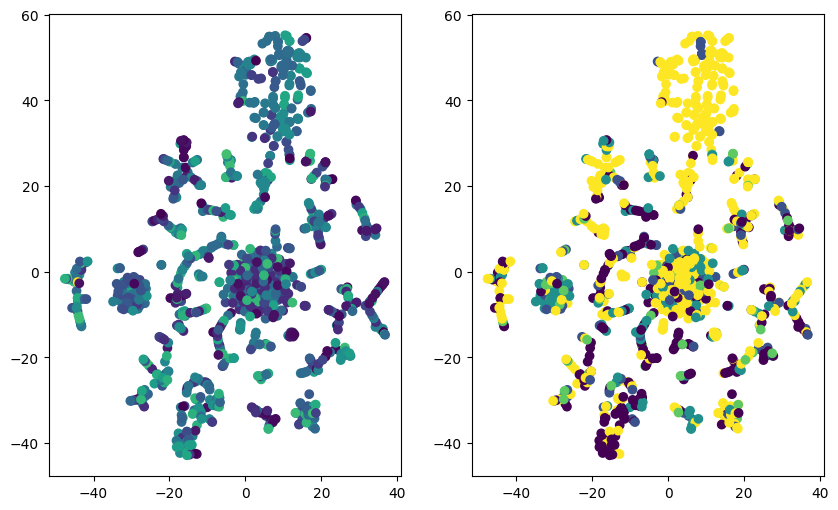

In [15]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
# by company age
plt.scatter(pos_embeddings[:, 0], pos_embeddings[:, 1], c = data_for_model[:, 0])

plt.subplot(122)
# company size
plt.scatter(pos_embeddings[:, 0], pos_embeddings[:, 1], c = data_for_model[:, 3])
plt.show()

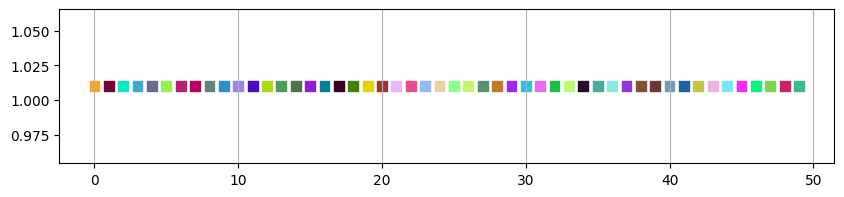

In [16]:
# colors to visualize different clusters
color_map_3 = []
for i in range(50):
    color_map_3.append('#%06x' % random.randint(0, 0xFFFFFF))

mapping_colors = {i: color for i, color in enumerate(color_map_3)}


plt.figure(figsize = (10, 2))
x = range(50)
y = [1.01 for i in range(50)]

plt.scatter(x, y, color=color_map_3, s=50, marker = 's')
plt.grid(axis = 'x')
plt.show()

Methods for clustering:
* Affinity propagation
* K-Means
* Mean-shift

**AffinityPropagation**

In [17]:
Preference = [-400, -350, -200, -150, -100, -80, -50, -30, -25]
mod = []
number_clusters = []
for preference in Preference:
    model = AffinityPropagation(preference=preference, random_state=42)
    model.fit(emb)
    labels = model.labels_

    communities = {}
    for node, label in zip(G_con.nodes(), labels):
      if label not in communities:
        communities[label] = []
      communities[label].append(node)
    number_clusters.append(len(communities))
    mod.append(nx.community.modularity(G_con, communities.values()))

display(pd.DataFrame([Preference, number_clusters, mod],
                     index = ['preference', 'number_clusters', 'modularity']).T.sort_values(by='modularity', ascending = False).head(5))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:140: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


,preference,number_clusters,modularity
4,-100.0,46.0,0.805992
5,-80.0,58.0,0.779875
3,-150.0,30.0,0.778774
6,-50.0,125.0,0.735169
7,-30.0,105.0,0.735129


In [18]:
af = AffinityPropagation(
    preference= -150,
    random_state=42).fit(emb)

labels = af.labels_

communities = {}
for node, label in zip(G_con.nodes(), labels):
    if label not in communities:
        communities[label] = []
    communities[label].append(node)

print('modularity =', nx.community.modularity(G_con, communities.values()))

###### visualization ########
# plt.figure(figsize = (20, 15))
# nodes_draw = nx.draw_networkx_nodes(G = G_con, pos = pos_emb,
#                        node_color = [mapping_colors[i] for i in labels],
#                        node_size = 100)

# edges_draw = nx.draw_networkx_edges(G = G_con, pos = pos_emb, width = 0.5)

modularity = 0.7787742701247167


**KMeans**

In [19]:
mod = []
for k in range(1, 40, 2):
  kmeans = KMeans(n_clusters=k, random_state = 42, algorithm = 'lloyd').fit(emb)
  labels = kmeans.labels_
  communities = {}
  for node, label in zip(G_con.nodes(), labels):
    if label not in communities:
      communities[label] = []
    communities[label].append(node)

  mod.append(nx.community.modularity(G_con, communities.values()))

display(pd.DataFrame([list(range(1, 40, 2)), mod],
                     index = ['kmeans', 'modularity']).T.sort_values(by='modularity', ascending = False).head(5))

,kmeans,modularity
17,35.0,0.803874
16,33.0,0.802846
14,29.0,0.801780
13,27.0,0.801129
15,31.0,0.801017


In [20]:
kmeans = KMeans(n_clusters=19, random_state = 42, algorithm='lloyd')
labels = kmeans.fit_predict(emb)

communities = {}
for node, label in zip(G_con.nodes(), labels):
    if label not in communities:
        communities[label] = []
    communities[label].append(node)

print('modularity =', nx.community.modularity(G_con, communities.values()))

###### visualization ########
# plt.figure(figsize = (20, 15))
# nodes_draw = nx.draw_networkx_nodes(G = G_con, pos = pos_emb,
#                        node_color = [mapping_colors[i] for i in labels],
#                        node_size = 100)

# edges_draw = nx.draw_networkx_edges(G = G_con, pos = pos_emb, width = 0.5)

modularity = 0.7935503140058106


**MeanShift**

In [21]:
mod = []
for k in tqdm(np.arange(0.5, 5, 0.2)):
  mean_shift = MeanShift(bandwidth=k).fit(emb)
  labels = mean_shift.labels_
  communities = {}
  for node, label in zip(G_con.nodes(), labels):
    if label not in communities:
      communities[label] = []
    communities[label].append(node)

  mod.append(nx.community.modularity(G_con, communities.values()))

display(pd.DataFrame([list(np.arange(0.5, 5, 0.2)), mod],
                     index = ['kmeans', 'modularity']).T.sort_values(by='modularity', ascending = False).head(5))

100%|██████████| 23/23 [01:17<00:00,  3.38s/it]


,kmeans,modularity
13,3.1,0.794949
12,2.9,0.789294
11,2.7,0.764494
14,3.3,0.719435
10,2.5,0.714133


In [22]:
mean_shift = MeanShift(bandwidth=3.1).fit(emb)
labels = mean_shift.labels_

communities = {}
for node, label in zip(G_con.nodes(), labels):
    if label not in communities:
        communities[label] = []
    communities[label].append(node)

print('modularity =', nx.community.modularity(G_con, communities.values()))

###### visualization ########
# plt.figure(figsize = (20, 15))
# nodes_draw = nx.draw_networkx_nodes(G = G_con, pos = pos_emb,
#                        node_color = [mapping_colors[i] for i in labels],
#                        node_size = 100)

# edges_draw = nx.draw_networkx_edges(G = G_con, pos = pos_emb, width = 0.5)

modularity = 0.7949492785395411


-----------

In [23]:
# results of work after applying Node2Vec
pd.DataFrame([['AffinityPropagation' , 0.78642], ['Kmeans' , 0.801095], ['MeanShift' , 0.80652]], columns = ['method', 'metrics'])

,method,metrics
0,AffinityPropagation,0.786420
1,Kmeans,0.801095
2,MeanShift,0.806520
